In [66]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [67]:
# IMPORT PACKAGES

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as feature
import cmocean.cm
import pandas as pd
import xarray as xr
import collections
# fix to cartopy issue right now
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

In [68]:
# ADDITIONAL FUNCTIONS

# CODE TO SHIFT CCSM DATA BY 1 MONTH (given weird NCAR conventions that calendar date is end of time bound for each month)

def shift_dates_1M(dat):
    y_first = str(dat.time.values[0].year).zfill(4)
    y_last = str(dat.time.values[-2].year).zfill(4)

    time2 = xr.cftime_range(start=str(y_first)+'-01-01', end=str(y_last)+'-12-01', freq="1MS", calendar="noleap")
    dat = dat.assign_coords(time=time2)
    return dat

In [69]:
# PATHS TO DATA FILES

# direc = '/tigress/GEOCLIM/janewb/MODEL_OUT'
# files = {}
# files['ctrl'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart/TIMESERIES/u.00010101-03000101.ocean.nc'
# files['cam'] = '/tigress/janewb/MODEL_OUT_HERE/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1_CAM/TIMESERIES/u.00010101-02050101.ocean.nc'
# files['hitopo'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1/TIMESERIES/u.00010101-06000101.ocean.nc'
# files['oscar'] = '/tigress/gvecchi/DATA/OSCAR/average_all_oscar.1993-2017.nc'
# files['cesm_ctrl'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_data/b40.1850.track1.1deg.006.pop.h.UVELsfc_regrid.120001-128212.nc'
# files['cesm_cam'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_data/ccsm4pi_topo2.pop.h.UVELsfc_regrid.020001-028212.nc'

direc = '/tigress/janewb/public_html/HITOPO/'
files = {}
files['ctrl'] = direc+'flor.ctrl.u.nc'
files['cam'] = direc+'flor.cam.u.nc'
files['hitopo'] = direc+'flor.hitopo.u.nc'
files['oscar'] = direc+'obs.oscar.u.nc'
files['cesm_ctrl'] = direc+'ccsm4.ctrl.u.nc'
files['cesm_cam'] = direc+'ccsm4.ideal_cam.u.nc'

In [70]:
# DATA CLEANING

dat = {}
u = {}
tsel = {}

x = 'lon'
y = 'lat'
u_var = 'u'
units = 'm/s'
model_tmin = '0031'
model_tmax = '0200'
calendars = {'ctrl':'noleap',
             'cam':'noleap',
             'hitopo':'noleap',
             'cesm_ctrl':'noleap',
             'cesm_cam':'noleap'
            }

In [71]:
# OBSERVATIONS

# OSCAR
dat['oscar'] = xr.open_dataset(files['oscar'])
u['oscar'] = dat['oscar'].rename({'U':'u'}).u
u['oscar'] = u['oscar'].rename({'LONGITUDE': 'lon','LATITUDE': 'lat'})
u['oscar'].attrs = dat['oscar'].attrs
u['oscar'].attrs['units'] = units
tsel['oscar'] = u['oscar'].sel(DEPTH=15)

In [85]:
# FLOR Runs
for key in ['ctrl','cam','hitopo']:
    dat[key] = xr.open_dataset(files[key]).rename({'xu_ocean': 'lon','yu_ocean': 'lat'})
    u[key] = dat[key].u
    u[key].attrs = dat[key].attrs
    u[key].attrs['units'] = units
    u[key] = u[key]
    tsel[key] = u[key].sel(time = slice(model_tmin,model_tmax)).sel(st_ocean=15)


In [86]:
# CESM Runs
for key in ['cesm_ctrl']:
    dat[key] = xr.open_dataset(files[key]).sel(time=slice('1200-02-01','1282-01-01'))
    dat[key] = shift_dates_1M(dat[key])
    dat[key] = dat[key].rename({'UVEL':'u'})
    u[key] = dat[key].u/100 # CONVERT FROM CM/S TO M/S
    u[key].attrs = dat[key].attrs
    u[key].attrs['units'] = units
    tsel[key] = u[key]
    
for key in ['cesm_cam']:
    dat[key] = xr.open_dataset(files[key]).sel(time=slice('0200-02-01','0282-01-01'))
    dat[key] = shift_dates_1M(dat[key])
    dat[key] = dat[key].rename({'UVEL':'u'})
    u[key] = dat[key].u/100 # CONVERT FROM CM/S TO M/S
    u[key].attrs = dat[key].attrs
    u[key].attrs['units'] = units
    tsel[key] = u[key]

In [45]:
# SAVE DATA TO NETCDF SO DON'T HAVE TO RECALCULATE EACH TIME
tsel['ctrl'].to_netcdf('CURRENTS/u_ctrl.nc')
tsel['cam'].to_netcdf('CURRENTS/u_cam.nc')
tsel['hitopo'].to_netcdf('CURRENTS/u_hitopo.nc')
tsel['oscar'].to_netcdf('CURRENTS/u_oscar.nc')
tsel['cesm_ctrl'].to_netcdf('CURRENTS/u_cesm_ctrl.nc')
tsel['cesm_cam'].to_netcdf('CURRENTS/u_cesm_cam.nc')

# If formatted data already can start from here.

In [65]:
# LOAD DATA
tsel = {}

tsel['ctrl'] = xr.open_dataset('CURRENTS/u_ctrl.nc').u
tsel['cam'] = xr.open_dataset('CURRENTS/u_cam.nc').u
tsel['hitopo'] = xr.open_dataset('CURRENTS/u_hitopo.nc').u
tsel['oscar'] = xr.open_dataset('CURRENTS/u_oscar.nc').u
tsel['oscar'] = xr.open_dataset('CURRENTS/u_oscar.nc').u
tsel['cesm_cam'] = xr.open_dataset('CURRENTS/u_cesm_cam.nc').u
tsel['cesm_ctrl'] = xr.open_dataset('CURRENTS/u_cesm_ctrl.nc').u

In [87]:
# DATA ANALYSIS

tmean = {}

calendars = {'ctrl':'noleap',
             'cam':'noleap',
             'hitopo':'noleap',
             'cesm_ctrl':'noleap',
             'cesm_cam':'noleap'
            }

for key in ['ctrl','cam','hitopo','cesm_cam','cesm_ctrl']:
    tmean[key] = tsel[key].mean(dim='time')
    
tmean['oscar'] = tsel['oscar']

/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [88]:
# EDIT GRIDS

for key in ['ctrl','cam','hitopo']:
    tmean[key] = tmean[key].assign_coords(lon=(tmean[key].lon % 360)).roll(lon=81, roll_coords=True)
    tmean[key] = tmean[key]#.sel(lon=slice(100,300))
    
tmean['oscar'] = tmean['oscar'].where(tsel['oscar']>-1e32)#.sel(lon=slice(100,300))

# CESM grid is fine

In [89]:
# CALCULATE DIFFERENCE BETWEEN DIFFERENT MODEL RUNS

mdiff = {}

for key in ['hitopo','cam']:
    mdiff[key] = tmean['ctrl'] - tmean[key]
    
mdiff[key] = tmean['cesm_ctrl'] - tmean['cesm_cam']


In [90]:
# REGRID AND CALCULATE DIFFERENCE FROM OBS

regrid = {}
diff = collections.defaultdict(dict)

regrid['oscar_flor'] = tmean['oscar'].interp_like(tmean['ctrl'],method='linear')
for run in ['ctrl','hitopo','cam']:
    diff['oscar'][run] = regrid['oscar_flor'] - tmean[run]

regrid['oscar_cesm'] = tmean['oscar'].interp_like(tmean['cesm_ctrl'],method='linear')
for run in ['cesm_ctrl','cesm_cam']:
    diff['oscar'][run] = regrid['oscar_cesm'] - tmean[run]

In [91]:
# REGION BOUNDS FOR PLOTTING
xmin = 100
xmax = 300
ymin = -23.5
ymax = 23.5

In [92]:
# CALCULATE DERIVATIVE AND SET BOUNDS FOR IT
x1=-170+360
x2=-110+360
y1 = 0.0
y2 = 15.0

deriv = {}
deriv['oscar_flor'] = regrid['oscar_flor'].sel(lat=slice(y1,y2)).sel(lon=slice(x1,x2)).mean('lon')
deriv['ctrl'] = tmean['ctrl'].sel(lat=slice(y1,y2)).sel(lon=slice(x1,x2)).mean('lon')
deriv['hitopo'] = tmean['hitopo'].sel(lat=slice(y1,y2)).sel(lon=slice(x1,x2)).mean('lon')
deriv['cam'] = tmean['cam'].sel(lat=slice(y1,y2)).sel(lon=slice(x1,x2)).mean('lon')
deriv['oscar_cesm'] = regrid['oscar_cesm'].sel(lat=slice(y1,y2)).sel(lon=slice(x1,x2)).mean('lon')
deriv['cesm_cam'] = tmean['cesm_cam'].sel(lat=slice(y1,y2)).sel(lon=slice(x1,x2)).mean('lon')
deriv['cesm_ctrl'] = tmean['cesm_ctrl'].sel(lat=slice(y1,y2)).sel(lon=slice(x1,x2)).mean('lon')
lats_o = deriv['oscar_flor'].lat
lats_oc = deriv['oscar_cesm'].lat
lats_m = deriv['ctrl'].lat
lats_cm = deriv['cesm_ctrl'].lat

Text(0, 0.5, 'zonal current [m/s]')

/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:745: RuntimeWarning: invalid value encountered in maximum
  x0 = np.maximum(bbox1.xmin, bbox2.xmin)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:746: RuntimeWarning: invalid value encountered in minimum
  x1 = np.minimum(bbox1.xmax, bbox2.xmax)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:747: RuntimeWarning: invalid value encountered in maximum
  y0 = np.maximum(bbox1.ymin, bbox2.ymin)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:748: RuntimeWarning: invalid value encountered in minimum
  y1 = np.minimum(bbox1.ymax, bbox2.ymax)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/

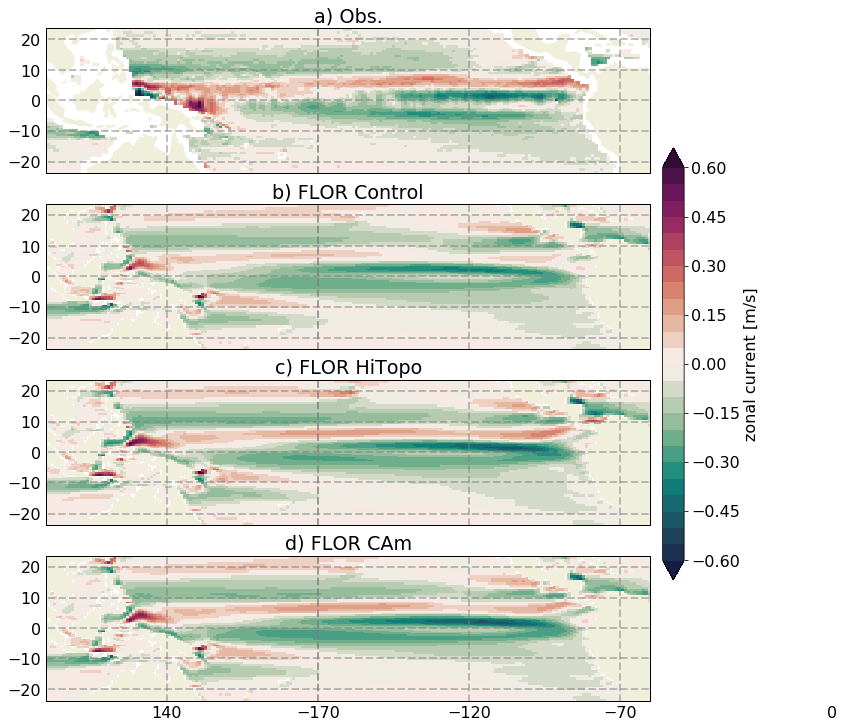

In [93]:
# FLOR MEAN CURRENTS IN OBS AND DIFFERENT MODEL RUNS

fig = plt.figure(constrained_layout=True, figsize=(12,10))
gs = fig.add_gridspec(4, 1)
plt.rcParams.update({'font.size': 16})

lev = np.arange(-0.6,0.65,0.05)
cmap = cmocean.cm.curl
proj = ccrs.Mercator(central_longitude=200)

ax1 = fig.add_subplot(gs[0, 0], projection = proj)
im1 = regrid['oscar_flor'].plot(ax=ax1, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax1.add_feature(feature.LAND, color = 'k')
ax1.set_title('a) Obs.')
ax1.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax2 = fig.add_subplot(gs[1, 0], projection = proj)
tmean['ctrl'].plot(ax=ax2, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax2.add_feature(feature.LAND, color = 'k')
ax2.set_title('b) FLOR Control')
ax2.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax3 = fig.add_subplot(gs[2, 0], projection = proj)
tmean['hitopo'].plot(ax=ax3, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax3.add_feature(feature.LAND, color = 'k')
ax3.set_title('c) FLOR HiTopo')
ax3.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax4 = fig.add_subplot(gs[3, 0], projection = proj)
tmean['cam'].plot(ax=ax4, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax4.add_feature(feature.LAND, color = 'k')
ax4.set_title('d) FLOR CAm')
ax4.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

#fig.subplots_adjust(wspace=0.7)
cb1_ax = fig.add_axes([0.81, 0.2, 0.025, 0.6])
cb1 = fig.colorbar(im1, cax=cb1_ax)
cb1.ax.set_ylabel('zonal current [m/s]', rotation=90)

#plt.tight_layout()

#plt.savefig('currents_flor.pdf')

Text(0, 0.5, 'zonal current [m/s]')

/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:745: RuntimeWarning: invalid value encountered in maximum
  x0 = np.maximum(bbox1.xmin, bbox2.xmin)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:746: RuntimeWarning: invalid value encountered in minimum
  x1 = np.minimum(bbox1.xmax, bbox2.xmax)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:747: RuntimeWarning: invalid value encountered in maximum
  y0 = np.maximum(bbox1.ymin, bbox2.ymin)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:748: RuntimeWarning: invalid value encountered in minimum
  y1 = np.minimum(bbox1.ymax, bbox2.ymax)


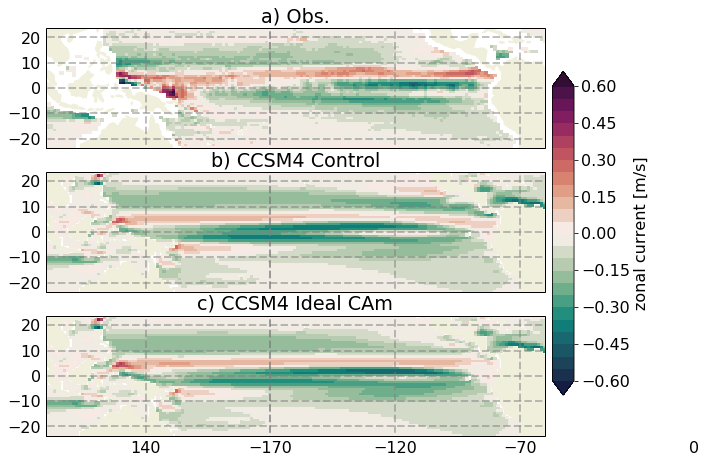

In [94]:
# CCSM4 MEAN CURRENTS IN OBS AND DIFFERENT MODEL RUNS

fig = plt.figure(figsize=(12,7.5))
plt.rcParams.update({'font.size': 16})

lev = np.arange(-0.6,0.65,0.05)
cmap = cmocean.cm.curl
proj = ccrs.Mercator(central_longitude=200)

ax1 = plt.subplot(3,1,1,projection=proj)
im1 = regrid['oscar_cesm'].plot(ax=ax1, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax1.add_feature(feature.LAND, color = 'k')
ax1.set_title('a) Obs.')
ax1.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax2 = plt.subplot(3,1,2,projection=proj)
tmean['cesm_ctrl'].plot(ax=ax2, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax2.add_feature(feature.LAND, color = 'k')
ax2.set_title('b) CCSM4 Control')
ax2.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax3 = plt.subplot(3,1,3,projection=proj)
tmean['cesm_cam'].plot(ax=ax3, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax3.add_feature(feature.LAND, color = 'k')
ax3.set_title('c) CCSM4 Ideal CAm')
ax3.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

#fig.subplots_adjust(wspace=0.7)
cb1_ax = fig.add_axes([0.81, 0.2, 0.025, 0.6])
cb1 = fig.colorbar(im1, cax=cb1_ax)
cb1.ax.set_ylabel('zonal current [m/s]', rotation=90)

#plt.tight_layout()

#plt.savefig('currents_cesm.pdf')

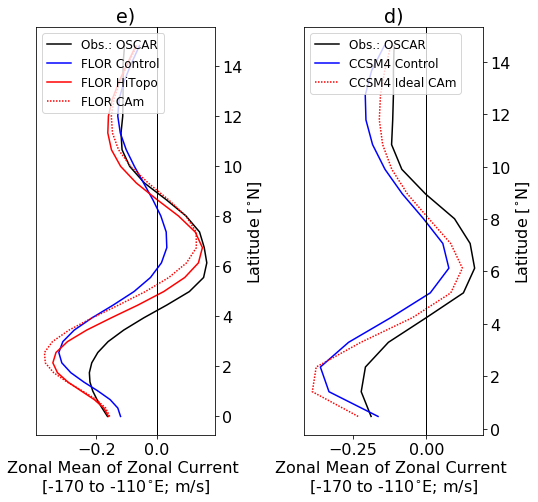

In [95]:
fig = plt.figure(figsize=(8,7.5))
plt.rcParams.update({'font.size': 16})


ax1 = plt.subplot(121)
plt.plot(deriv['oscar_flor'],lats_o,color='k',label='Obs.: OSCAR')
plt.plot(deriv['ctrl'],lats_m,color='b',label='FLOR Control')
plt.plot(deriv['hitopo'],lats_m,color='r',label='FLOR HiTopo')
plt.plot(deriv['cam'],lats_m,color='r',dashes=[1,1,1,1],label='FLOR CAm')
ax1.yaxis.tick_right()
plt.xlabel('Zonal Mean of Zonal Current \n[-170 to -110$^{\circ}$E; m/s]')
ax1.yaxis.set_label_position("right")
plt.ylabel('Latitude [$^{\circ}$N]')
plt.title('e)')
plt.legend(fontsize=12,loc='upper left')
plt.axvline(x=0,color='k',linewidth=1)

ax2 = plt.subplot(122)
plt.plot(deriv['oscar_cesm'],lats_oc,color='k',label='Obs.: OSCAR')
plt.plot(deriv['cesm_ctrl'],lats_cm,color='b',label='CCSM4 Control')
plt.plot(deriv['cesm_cam'],lats_cm,color='r',dashes=[1,1,1,1],label='CCSM4 Ideal CAm')
ax2.yaxis.tick_right()
plt.xlabel('Zonal Mean of Zonal Current \n[-170 to -110$^{\circ}$E; m/s]')
ax2.yaxis.set_label_position("right")
plt.ylabel('Latitude [$^{\circ}$N]')
plt.title('d)')
plt.legend(fontsize=12, loc = 'upper left')
plt.axvline(x=0,color='k',linewidth=1)

fig.subplots_adjust(wspace=0.5, hspace = 0.38)


#plt.savefig('zonalintzonalcurrents.pdf')